In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib.pyplot as plt
import scipy.signal as signal
import math
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/hogfeatures/picture2.png
/kaggle/input/hogfeatures/deepika.jpg
/kaggle/input/hogfeatures/woman-dog-walking.jpg
/kaggle/input/hogfeatures/picture1.png
/kaggle/input/hogfeatures/man-walking.jpg
/kaggle/input/hogfeatures/two-walking.jpg
/kaggle/input/hogfeatures/dog-walking.jpg
/kaggle/input/hogfeatures/person.png


Orginal img Size (291, 173)
Resize img Size (291, 173)


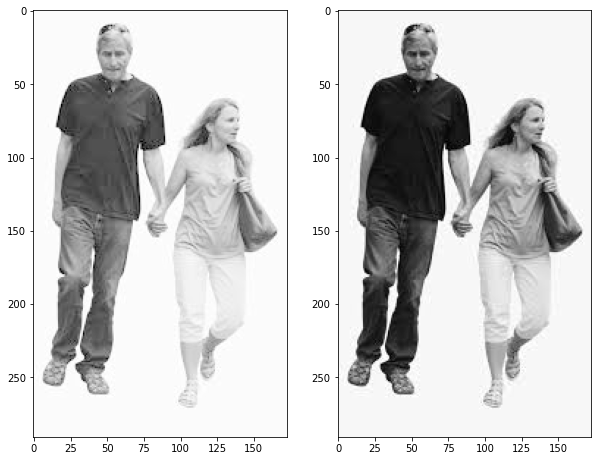

In [2]:
img=cv2.imread('../input/hogfeatures/two-walking.jpg',0)
resizedimg = cv2.resize(img, (img.shape[1],img.shape[0]), interpolation = cv2.INTER_AREA)
resizedimg=np.sqrt(resizedimg/float(np.max(resizedimg)))
resizedimg=resizedimg*255
f=plt.figure(figsize=(10,10))
f.add_subplot(1,2,1)
plt.imshow(resizedimg,cmap='gray')
f.add_subplot(1,2,2)
plt.imshow(img,cmap='gray')
print('Orginal img Size',img.shape)
print('Resize img Size',resizedimg.shape)

In [3]:
height,width=resizedimg.shape
cellsize = 8
binsize =9
angleunit=360/9
print('height',height)
print('width',width)
OrientaionArray=np.zeros((int(height / cellsize),int(width / cellsize),binsize),np.float32)
print('OrientaionArray' , OrientaionArray.shape)

height 291
width 173
OrientaionArray (36, 21, 9)


In [4]:
sobel_x=np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
sobel_y=np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
print('sobel_x',sobel_x)
print('sobel_y',sobel_y)

sobel_x [[-1  0  1]
 [-2  0  2]
 [-1  0  1]]
sobel_y [[ 1  2  1]
 [ 0  0  0]
 [-1 -2 -1]]


Text(0.5, 1.0, 'Y - Direction')

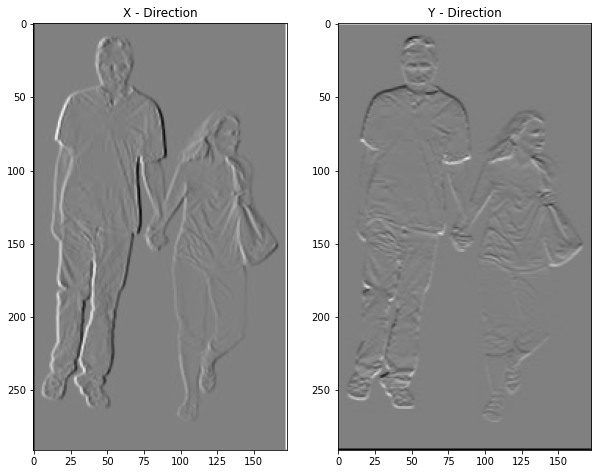

In [5]:
img_xdirection=signal.convolve2d(resizedimg,sobel_x,mode='same')
img_ydirection=signal.convolve2d(resizedimg,sobel_y,mode='same')

f=plt.figure(figsize=(10,10))
f.add_subplot(1,2,1)
plt.imshow(img_xdirection,cmap='gray')
plt.title('X - Direction')
f.add_subplot(1,2,2)
plt.imshow(img_ydirection,cmap='gray')
plt.title('Y - Direction')

Text(0.5, 1.0, 'Gradient Magnitude Threshold > 400')

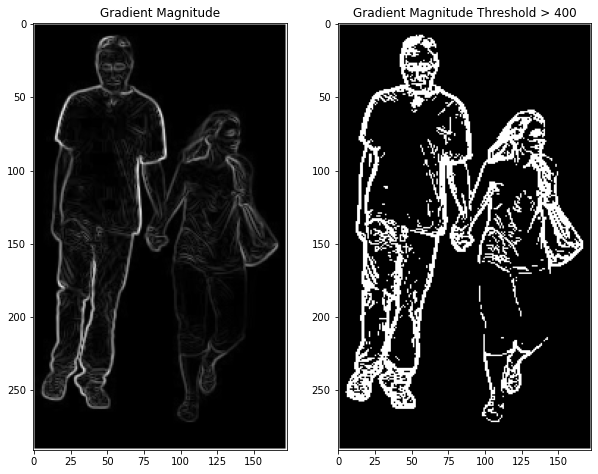

In [6]:
gradient_magnitute=np.sqrt(img_xdirection**2+img_ydirection**2)
f=plt.figure(figsize=(10,10))
f.add_subplot(1,2,1)
plt.imshow(gradient_magnitute,cmap='gray')
plt.title('Gradient Magnitude')
gradient_magnitute_thr=gradient_magnitute>100
f.add_subplot(1,2,2)
plt.imshow(gradient_magnitute_thr,cmap='gray')
plt.title('Gradient Magnitude Threshold > 400')

Min Angle 0.0
Max Angle 0.0


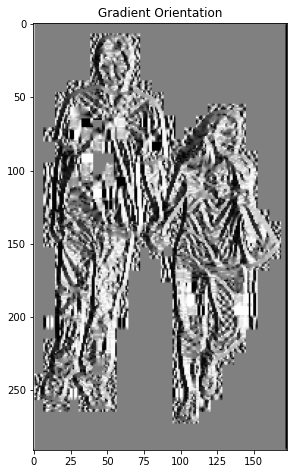

In [7]:
gradient_orientation=np.arctan2(img_ydirection,img_xdirection)
gradient_orientation=np.abs(gradient_orientation*(360/np.pi))
f=plt.figure(figsize=(10,10))
f.add_subplot(1,2,1)
plt.imshow(gradient_orientation,cmap='gray')
plt.title('Gradient Orientation')
print('Min Angle',min(gradient_orientation.flatten()))
print('Max Angle',min(gradient_orientation.flatten()))

In [8]:
print('gradient_orientation shape : ',gradient_orientation.shape)
print('gradient_magnitute Shape   : ',gradient_magnitute.shape)

gradient_orientation shape :  (291, 173)
gradient_magnitute Shape   :  (291, 173)


In [9]:
def Calculate_CloseBin(gradient_mag,gradient_angles):
    bin_array=[0]*binsize
    for i in range(gradient_mag.shape[0]):
        for j in range(gradient_mag.shape[1]):
            bin1=int(gradient_angles[i][j]/angleunit)
            if bin1 == binsize:
                bin1=bin1-1
            bin_array[bin1] +=gradient_mag[i][j]
        return bin_array

In [10]:
def render_gradient(image, cell_gradient):
        cell_width = cellsize / 2
        max_mag = np.array(cell_gradient).max()
        for x in range(cell_gradient.shape[0]):
            for y in range(cell_gradient.shape[1]):
                cell_grad = cell_gradient[x][y]
                cell_grad /= max_mag
                angle = 0
                angle_gap = angleunit
                for magnitude in cell_grad:
                    angle_radian = math.radians(angle)
                    x1 = int(x * cellsize + magnitude * cell_width * math.cos(angle_radian))
                    y1 = int(y * cellsize + magnitude * cell_width * math.sin(angle_radian))
                    x2 = int(x * cellsize - magnitude * cell_width * math.cos(angle_radian))
                    y2 = int(y * cellsize - magnitude * cell_width * math.sin(angle_radian))
                    cv2.line(image, (y1, x1), (y2, x2), int(255 * math.sqrt(magnitude)))
                    angle += angle_gap
        return image

In [11]:
hog_vector = []
hogimage=np.zeros(gradient_magnitute.shape)
for i in range(OrientaionArray.shape[0]):
    for j in range (OrientaionArray.shape[1]):
        gradient_mag=gradient_magnitute[i*cellsize:(i+1)*cellsize,j*cellsize:(j+1)*cellsize]
        gradient_angles=gradient_orientation[i*cellsize:(i+1)*cellsize,j*cellsize:(j+1)*cellsize]
        bin_array=Calculate_CloseBin(gradient_mag,gradient_angles)
        OrientaionArray[i][j]=bin_array
    hogimage=render_gradient(hogimage,OrientaionArray)
for m in range(OrientaionArray.shape[0]-1):
    for n in range(OrientaionArray.shape[1]-1):
        blockvector=[]
        blockvector.extend(OrientaionArray[m][n])
        blockvector.extend(OrientaionArray[m][n+1])
        blockvector.extend(OrientaionArray[m+1][n])
        blockvector.extend(OrientaionArray[m+1][n+1])
        magvector=[vector**2 for vector in blockvector]
        mag=0
        for scaler in magvector:
            mag +=scaler
        magnitute=np.sqrt(mag)
        if(magnitute !=0):
            hog_vector.append([vector/magnitute for vector in blockvector])
        else :
            hog_vector.append(blockvector)

             

Text(0.5, 1.0, 'HOG Image')

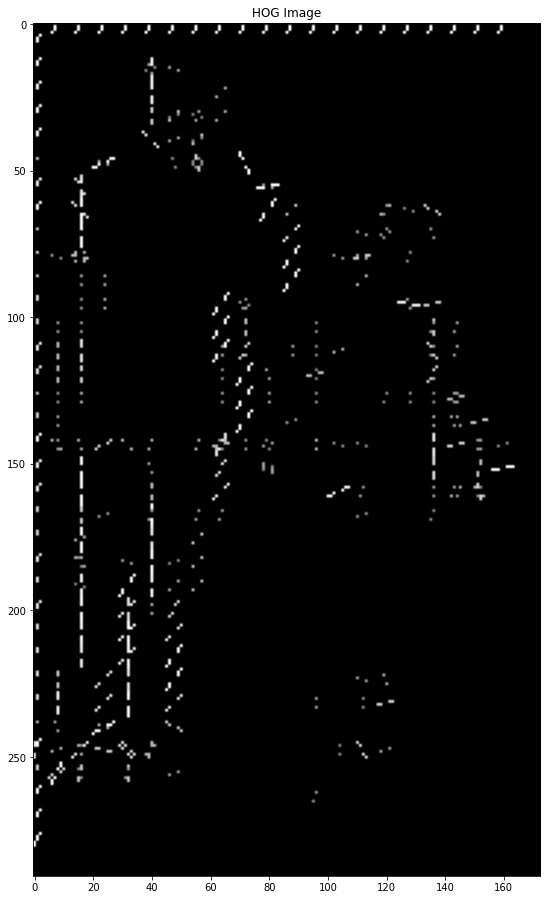

In [12]:
f=plt.figure(figsize=(20,20))
f.add_subplot(1,2,1)
plt.imshow(hogimage,cmap='gray')
plt.title('HOG Image')

In [13]:
print('HOG Vector',np.array(hog_vector).shape)

HOG Vector (700, 36)
